<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/main/TreatmentValidation_Candy_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import make_scorer, balanced_accuracy_score


from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut  , StratifiedKFold , cross_val_score
from scipy.stats import uniform , randint

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [2]:
data = pd.read_csv ("/content/candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [3]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [4]:
data.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent'],
      dtype='object')

In [5]:
c1 = data ['chocolate'] == 0
c2 = data ['fruity'] == 0
c  = c1 & c2

data ["other_candy"] = np.where (c , 1 , 0)

In [6]:
data ["winpercent"] = data ["winpercent"] / 100

In [7]:
decision_cols = ['chocolate', 'fruity', 'other_candy' ,'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']
cont_cols     = ['sugarpercent','winpercent' ,'pricepercent' ]

array([[<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'fruity'}>,
        <Axes: title={'center': 'other_candy'}>],
       [<Axes: title={'center': 'caramel'}>,
        <Axes: title={'center': 'peanutyalmondy'}>,
        <Axes: title={'center': 'nougat'}>],
       [<Axes: title={'center': 'crispedricewafer'}>,
        <Axes: title={'center': 'hard'}>,
        <Axes: title={'center': 'bar'}>],
       [<Axes: title={'center': 'pluribus'}>, <Axes: >, <Axes: >]],
      dtype=object)

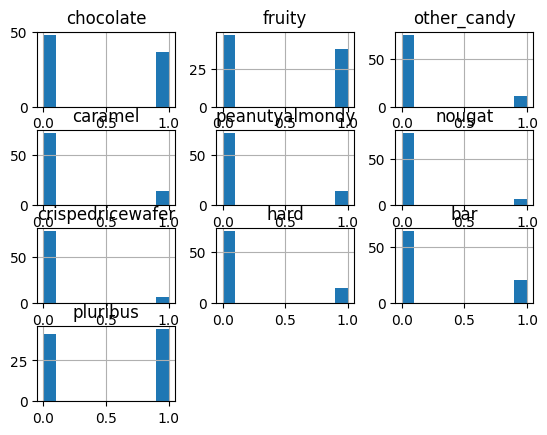

In [8]:
data [decision_cols].hist ()

In [9]:
data [decision_cols].nunique ()

chocolate           2
fruity              2
other_candy         2
caramel             2
peanutyalmondy      2
nougat              2
crispedricewafer    2
hard                2
bar                 2
pluribus            2
dtype: int64

In [10]:
data [decision_cols].corr ()

,chocolate,fruity,other_candy,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus
chocolate,1.000000,-0.741721,-0.338502,0.249875,0.377824,0.254892,0.341210,-0.344177,0.597421,-0.339675
fruity,-0.741721,1.000000,-0.346676,-0.335485,-0.399280,-0.269367,-0.269367,0.390678,-0.515066,0.299725
other_candy,-0.338502,-0.346676,1.000000,0.112284,0.017787,0.012000,-0.115500,0.005408,-0.139586,0.021456
caramel,0.249875,-0.335485,0.112284,1.000000,0.059356,0.328493,0.213113,-0.122355,0.333960,-0.269585
peanutyalmondy,0.377824,-0.399280,0.017787,0.059356,1.000000,0.213113,-0.017646,-0.205557,0.260420,-0.206109
nougat,0.254892,-0.269367,0.012000,0.328493,0.213113,1.000000,-0.089744,-0.138675,0.522976,-0.310339
crispedricewafer,0.341210,-0.269367,-0.115500,0.213113,-0.017646,-0.089744,1.000000,-0.138675,0.423751,-0.224693
hard,-0.344177,0.390678,0.005408,-0.122355,-0.205557,-0.138675,-0.138675,1.000000,-0.265165,0.014532
bar,0.597421,-0.515066,-0.139586,0.333960,0.260420,0.522976,0.423751,-0.265165,1.000000,-0.593409
pluribus,-0.339675,0.299725,0.021456,-0.269585,-0.206109,-0.310339,-0.224693,0.014532,-0.593409,1.000000


In [11]:
data [decision_cols].corr () [['chocolate']].apply(lambda x : abs (x)).sort_values ("chocolate")

,chocolate
caramel,0.249875
nougat,0.254892
other_candy,0.338502
pluribus,0.339675
crispedricewafer,0.341210
hard,0.344177
peanutyalmondy,0.377824
bar,0.597421
fruity,0.741721
chocolate,1.000000


In [12]:
#'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
#       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus'

ordered_decision_cols = data [decision_cols].corr () [['chocolate']].apply(lambda x : abs (x)).sort_values ("chocolate",ascending =False) .index.values
ordered_decision_cols

array(['chocolate', 'fruity', 'bar', 'peanutyalmondy', 'hard',
       'crispedricewafer', 'pluribus', 'other_candy', 'nougat', 'caramel'],
      dtype=object)

In [16]:
reordered_decision_cols = ['chocolate', 'fruity' , 'other_candy' , 'peanutyalmondy', 'hard',
       'crispedricewafer', 'pluribus',  'nougat', 'caramel']

In [17]:
data [reordered_decision_cols]

,chocolate,fruity,other_candy,peanutyalmondy,hard,crispedricewafer,pluribus,nougat,caramel
0,1,0,0,0,0,1,0,0,1
1,1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
80,0,1,0,0,0,0,0,0,0
81,0,1,0,0,1,0,0,0,0
82,0,1,0,0,0,0,1,0,0
83,0,0,1,0,1,0,0,0,1


In [20]:
data [cont_cols]

,sugarpercent,winpercent,pricepercent
0,0.732,0.669717,0.860
1,0.604,0.676029,0.511
2,0.011,0.322611,0.116
3,0.011,0.461165,0.511
4,0.906,0.523415,0.511
...,...,...,...
80,0.220,0.454663,0.116
81,0.093,0.390119,0.116
82,0.313,0.443755,0.313
83,0.186,0.419043,0.267


In [36]:
# Store models and their accuracies
models     = []
accuracies = []
feature_imp = []
feature_imp_dfs = []
for i in range(data [reordered_decision_cols].shape[1]):
    # Use the i-th column as the target, and all others as features
    X = data [reordered_decision_cols].drop (reordered_decision_cols [i] ,axis =1)
    X = pd.concat ([data [cont_cols],X],axis =1)
    y = data [reordered_decision_cols].iloc [:, i]

    # Initialize and train the RandomForest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Store the model
    models.append(model)

    # Evaluate and store accuracy
    y_pred = model.predict(X)
    accuracy = balanced_accuracy_score (y, y_pred , adjusted=True)
    accuracies.append(accuracy)
    print(f"Model {i+1} (predicting variable {i+1}): Accuracy = {accuracy:.2f}" , reordered_decision_cols [i])

    feature_imp.append (model.feature_importances_)

    print (X.columns)
    feature_imp_dfs.append ( pd.DataFrame ([feature_imp [i]] , columns = X.columns) )

Model 1 (predicting variable 1): Accuracy = 1.00 chocolate
Index(['sugarpercent', 'winpercent', 'pricepercent', 'fruity', 'other_candy',
       'peanutyalmondy', 'hard', 'crispedricewafer', 'pluribus', 'nougat',
       'caramel'],
      dtype='object')
Model 2 (predicting variable 2): Accuracy = 1.00 fruity
Index(['sugarpercent', 'winpercent', 'pricepercent', 'chocolate',
       'other_candy', 'peanutyalmondy', 'hard', 'crispedricewafer', 'pluribus',
       'nougat', 'caramel'],
      dtype='object')
Model 3 (predicting variable 3): Accuracy = 1.00 other_candy
Index(['sugarpercent', 'winpercent', 'pricepercent', 'chocolate', 'fruity',
       'peanutyalmondy', 'hard', 'crispedricewafer', 'pluribus', 'nougat',
       'caramel'],
      dtype='object')
Model 4 (predicting variable 4): Accuracy = 1.00 peanutyalmondy
Index(['sugarpercent', 'winpercent', 'pricepercent', 'chocolate', 'fruity',
       'other_candy', 'hard', 'crispedricewafer', 'pluribus', 'nougat',
       'caramel'],
      dtyp

In [37]:
feature_imp[1]

array([0.0465477 , 0.11182489, 0.13445674, 0.3599689 , 0.19217285,
       0.0271744 , 0.05731603, 0.00804777, 0.0235308 , 0.01054653,
       0.02841339])

In [38]:
decsion_df = pd.DataFrame (reordered_decision_cols)
decsion_df

,0
0,chocolate
1,fruity
2,other_candy
3,peanutyalmondy
4,hard
5,crispedricewafer
6,pluribus
7,nougat
8,caramel


In [39]:
feature_imp_dfs

[   sugarpercent  winpercent  pricepercent    fruity  other_candy  \
 0      0.058162    0.219955      0.155312  0.345621     0.112841   
 
    peanutyalmondy      hard  crispedricewafer  pluribus    nougat   caramel  
 0        0.011519  0.024078          0.013377  0.034693  0.011081  0.013361  ,
    sugarpercent  winpercent  pricepercent  chocolate  other_candy  \
 0      0.046548    0.111825      0.134457   0.359969     0.192173   
 
    peanutyalmondy      hard  crispedricewafer  pluribus    nougat   caramel  
 0        0.027174  0.057316          0.008048  0.023531  0.010547  0.028413  ,
    sugarpercent  winpercent  pricepercent  chocolate    fruity  \
 0      0.129697    0.248864      0.091213    0.17051  0.263436   
 
    peanutyalmondy      hard  crispedricewafer  pluribus    nougat  caramel  
 0        0.026148  0.012553          0.003149  0.011739  0.019231  0.02346  ,
    sugarpercent  winpercent  pricepercent  chocolate    fruity  other_candy  \
 0      0.128905    0.36396

In [40]:
feature_imp_dfs [0]

,sugarpercent,winpercent,pricepercent,fruity,other_candy,peanutyalmondy,hard,crispedricewafer,pluribus,nougat,caramel
0,0.058162,0.219955,0.155312,0.345621,0.112841,0.011519,0.024078,0.013377,0.034693,0.011081,0.013361


In [41]:
feature_imp_dfs [1]

,sugarpercent,winpercent,pricepercent,chocolate,other_candy,peanutyalmondy,hard,crispedricewafer,pluribus,nougat,caramel
0,0.046548,0.111825,0.134457,0.359969,0.192173,0.027174,0.057316,0.008048,0.023531,0.010547,0.028413


In [42]:
imp_df = pd.concat (feature_imp_dfs)
imp_df

,sugarpercent,winpercent,pricepercent,fruity,other_candy,peanutyalmondy,hard,crispedricewafer,pluribus,nougat,caramel,chocolate
0,0.058162,0.219955,0.155312,0.345621,0.112841,0.011519,0.024078,0.013377,0.034693,0.011081,0.013361,NaN
0,0.046548,0.111825,0.134457,NaN,0.192173,0.027174,0.057316,0.008048,0.023531,0.010547,0.028413,0.359969
0,0.129697,0.248864,0.091213,0.263436,NaN,0.026148,0.012553,0.003149,0.011739,0.019231,0.023460,0.170510
0,0.128905,0.363965,0.228509,0.044409,0.014241,NaN,0.006397,0.039737,0.029867,0.061905,0.033488,0.048578
0,0.231091,0.287493,0.251265,0.072124,0.014338,0.006726,NaN,0.001024,0.038690,0.002136,0.028587,0.066526
0,0.160473,0.351623,0.213993,0.014336,0.001980,0.061408,0.004076,NaN,0.048892,0.038130,0.061129,0.043960
0,0.252431,0.264666,0.193066,0.043132,0.017982,0.017504,0.024589,0.021164,NaN,0.048879,0.053229,0.063358
0,0.176426,0.232343,0.165850,0.032145,0.032842,0.067348,0.007821,0.059209,0.076382,NaN,0.108827,0.040808
0,0.222287,0.276192,0.171932,0.040147,0.025242,0.032651,0.024044,0.044277,0.055110,0.083579,NaN,0.024539


In [43]:
imp_df ["Decisions"] = reordered_decision_cols

In [44]:
imp_df ["Accuracies"] = accuracies
imp_df

,sugarpercent,winpercent,pricepercent,fruity,other_candy,peanutyalmondy,hard,crispedricewafer,pluribus,nougat,caramel,chocolate,Decisions,Accuracies
0,0.058162,0.219955,0.155312,0.345621,0.112841,0.011519,0.024078,0.013377,0.034693,0.011081,0.013361,NaN,chocolate,1.0
0,0.046548,0.111825,0.134457,NaN,0.192173,0.027174,0.057316,0.008048,0.023531,0.010547,0.028413,0.359969,fruity,1.0
0,0.129697,0.248864,0.091213,0.263436,NaN,0.026148,0.012553,0.003149,0.011739,0.019231,0.023460,0.170510,other_candy,1.0
0,0.128905,0.363965,0.228509,0.044409,0.014241,NaN,0.006397,0.039737,0.029867,0.061905,0.033488,0.048578,peanutyalmondy,1.0
0,0.231091,0.287493,0.251265,0.072124,0.014338,0.006726,NaN,0.001024,0.038690,0.002136,0.028587,0.066526,hard,1.0
0,0.160473,0.351623,0.213993,0.014336,0.001980,0.061408,0.004076,NaN,0.048892,0.038130,0.061129,0.043960,crispedricewafer,1.0
0,0.252431,0.264666,0.193066,0.043132,0.017982,0.017504,0.024589,0.021164,NaN,0.048879,0.053229,0.063358,pluribus,1.0
0,0.176426,0.232343,0.165850,0.032145,0.032842,0.067348,0.007821,0.059209,0.076382,NaN,0.108827,0.040808,nougat,1.0
0,0.222287,0.276192,0.171932,0.040147,0.025242,0.032651,0.024044,0.044277,0.055110,0.083579,NaN,0.024539,caramel,1.0


In [46]:
np.mean (imp_df .iloc [:,:3] , axis= 1)

0    0.144476
0    0.097610
0    0.156591
0    0.240460
0    0.256616
0    0.242030
0    0.236721
0    0.191540
0    0.223471
dtype: float64

In [51]:
np.mean (imp_df.iloc [:,3:9] , axis= 0)

fruity              0.106919
other_candy         0.051455
peanutyalmondy      0.031310
hard                0.020109
crispedricewafer    0.023748
pluribus            0.039863
dtype: float64

In [52]:
imp_df ["main_cols_mean"] = np.mean (imp_df .iloc [:,:3].iloc [:,:3] , axis= 1)
imp_df ["other_cols_mean"] = np.mean (imp_df .iloc [:,3:9] , axis= 1)
imp_df ["ratio"]          = imp_df ["main_cols_mean"] / imp_df ["other_cols_mean"]
imp_df ["Accuracies"] = accuracies
imp_df ["Decisions"] = reordered_decision_cols
imp_df.sort_values ("Accuracies")

,sugarpercent,winpercent,pricepercent,fruity,other_candy,peanutyalmondy,hard,crispedricewafer,pluribus,nougat,caramel,chocolate,Decisions,Accuracies,main_cols_mean,other_cols_mean,ratio
0,0.058162,0.219955,0.155312,0.345621,0.112841,0.011519,0.024078,0.013377,0.034693,0.011081,0.013361,NaN,chocolate,1.0,0.144476,0.090355,1.598990
0,0.046548,0.111825,0.134457,NaN,0.192173,0.027174,0.057316,0.008048,0.023531,0.010547,0.028413,0.359969,fruity,1.0,0.097610,0.061648,1.583331
0,0.129697,0.248864,0.091213,0.263436,NaN,0.026148,0.012553,0.003149,0.011739,0.019231,0.023460,0.170510,other_candy,1.0,0.156591,0.063405,2.469699
0,0.128905,0.363965,0.228509,0.044409,0.014241,NaN,0.006397,0.039737,0.029867,0.061905,0.033488,0.048578,peanutyalmondy,1.0,0.240460,0.026930,8.929032
0,0.231091,0.287493,0.251265,0.072124,0.014338,0.006726,NaN,0.001024,0.038690,0.002136,0.028587,0.066526,hard,1.0,0.256616,0.026580,9.654386
0,0.160473,0.351623,0.213993,0.014336,0.001980,0.061408,0.004076,NaN,0.048892,0.038130,0.061129,0.043960,crispedricewafer,1.0,0.242030,0.026138,9.259598
0,0.252431,0.264666,0.193066,0.043132,0.017982,0.017504,0.024589,0.021164,NaN,0.048879,0.053229,0.063358,pluribus,1.0,0.236721,0.024874,9.516710
0,0.176426,0.232343,0.165850,0.032145,0.032842,0.067348,0.007821,0.059209,0.076382,NaN,0.108827,0.040808,nougat,1.0,0.191540,0.045958,4.167732
0,0.222287,0.276192,0.171932,0.040147,0.025242,0.032651,0.024044,0.044277,0.055110,0.083579,NaN,0.024539,caramel,1.0,0.223471,0.036912,6.054170
